# Projet 4 : Segmentez des clients d'un site e-commerce
# Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation

## 1. Importation des données

### 1.1. Chargement des librairies

In [1]:
# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")  # style choisi pour les graphes

# Outils de sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.cluster import pair_confusion_matrix

# Modèles de sklearn
from sklearn.cluster import KMeans

# Utilisation du module nb_black pour formater le code
%load_ext nb_black

<IPython.core.display.Javascript object>

### 1.2. Chargement des données

In [2]:
df_all = pd.read_csv("all_data2.csv", index_col=0)

<IPython.core.display.Javascript object>

### 1.3. Préparation des données

In [3]:
# Mise au format datetime pour la colonne 'order_purchase_timestamp'
df_all["order_purchase_timestamp"] = pd.to_datetime(df_all["order_purchase_timestamp"])

<IPython.core.display.Javascript object>

In [4]:
def crea_df(df_init, date_fin):

    """ Fonction pour créer à partir du dataframe contenant toutes les données
    un dataframe jusqu'à une date choisie, avec les variables utilisées 
    pour la modélisation en les recalculant 
        
    - Arguments :
        - df_init : dataframe avec toutes les données 
        - date_fin : inclusion des données jusqu'à cette date INCLUSE
    
    - Retourne :
        - 1 dataframe :  avec les variables nécessaires à la modélisation
        recalculées
    """

    # Récupèration des données sur la période désirée
    df_time = df_init.loc[df_init["order_purchase_timestamp"] <= date_fin]

    # Sélection des colonnes à garder pour faire les manipulations
    col_select = [
        "customer_id",
        "customer_unique_id",
        "order_id",
        "order_purchase_timestamp",
        "order_item_id",
        "price",
        "freight_value",
        "review_score",
    ]

    # Tri par la plus récente "review_creation_date"
    df_time = df_time.sort_values(
        ["review_creation_date"], ascending=False
    ).reset_index(drop=True)

    # Sélection des données selon les colonnes à garder
    df_time = df_time[col_select]

    # Suppression des doublons au niveau de chaque commande
    # et de chaque produit
    # car plusieurs moyens de paiement et plusieurs review_creation_date
    # pour un même order_item_ide sont possibles
    df = (
        df_time.drop_duplicates(["customer_id", "order_item_id"], keep="first")
        .sort_values(["customer_unique_id"], ascending=False)
        .reset_index(drop=True)
    )

    # Dataframe avec juste la liste des customer_unique_id
    df_final = pd.DataFrame(
        df["customer_unique_id"].unique(), columns=["customer_unique_id"]
    )

    # Nombre de commandes faites par customer_unique_id
    df_nb_cmd = df.groupby("customer_unique_id")["customer_id"].nunique()
    df_nb_cmd.rename("nb_cmd", inplace=True)

    # Création de la colonne total_price
    df["total_price"] = df["price"] + df["freight_value"]
    # Montant dépensé par customer_unique_id
    df_montant = df.groupby("customer_unique_id")["total_price"].sum()
    df_montant.rename("montant_dep", inplace=True)

    # Date d'achat la plus récente par customer_unique_id
    df_last_time = df.groupby("customer_unique_id")["order_purchase_timestamp"].max()
    df_last_time.rename("last_time_cmd", inplace=True)

    # Nombre total de produits commandés par customer_unique_id
    df_nb_prod = df.groupby("customer_unique_id")["order_item_id"].count()
    df_nb_prod.rename("nb_prod", inplace=True)

    # Note moyenne par customer_unique_id
    df_note_moy = (
        df.groupby(["customer_unique_id", "customer_id"])["review_score"]
        .mean()
        .groupby(["customer_unique_id"])
        .mean()
    )
    df_note_moy.rename("note_moy", inplace=True)

    # Liste avec les nouvelles colonnes créées
    new_col = [df_last_time, df_nb_cmd, df_montant, df_nb_prod, df_note_moy]

    # Fusion avec le dataset de la liste des customer_unique_id
    for col in new_col:
        df_final = pd.merge(df_final, col, on="customer_unique_id", how="right")

    # Création de la colonne qui indique le nombre
    # de jours depuis la date de fin retenue
    df_final["nb_jours_last_cmd"] = (
        date_fin - df_final["last_time_cmd"]
    ) / np.timedelta64(1, "D")

    # Suppression de la colonne 'last_time_cmd'
    df_final = df_final.drop("last_time_cmd", axis=1)

    # Arrondi des notes à un chiffre après la virgule
    df_final.note_moy = df_final.note_moy.round(1)

    # Indexation sur 'customer_unique_id'
    df_final = df_final.set_index("customer_unique_id")

    return df_final

<IPython.core.display.Javascript object>

In [5]:
# Date la plus récente du dataset global
last_date = df_all["order_purchase_timestamp"].max()
last_date

Timestamp('2018-09-03 09:06:57')

<IPython.core.display.Javascript object>

In [6]:
# Date la plus ancienne du dataset global
first_date = df_all["order_purchase_timestamp"].min()
first_date

Timestamp('2016-09-04 21:15:19')

<IPython.core.display.Javascript object>

In [7]:
# Vérification qu'on retombe bien sur le dataset global
# si on applique la fonction sur l'intégralité des données
X_all = crea_df(df_all, last_date)
X_all.describe()

,nb_cmd,montant_dep,nb_prod,note_moy,nb_jours_last_cmd
count,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000
mean,1.033742,165.748545,1.179318,4.102190,243.081803
std,0.210529,227.106060,0.616014,1.327064,153.162612
min,1.000000,9.590000,1.000000,1.000000,0.000000
25%,1.000000,63.100000,1.000000,4.000000,118.845509
50%,1.000000,107.850000,1.000000,5.000000,223.665006
75%,1.000000,182.910000,1.000000,5.000000,352.406001
max,16.000000,13664.080000,24.000000,5.000000,728.494190


<IPython.core.display.Javascript object>

On retombe bien sur les mêmes informations.

## 2. Modélisation
### 2.1. Dataset période de base 1 : sept 2016 - déc 2017

On va prendre comme premier dataset un dataset qui couvre septembre 2016 à décembre 2017 inclus.

In [8]:
# Date limite
date_limit_1 = np.datetime64("2017-12-31 23:59:59")

# Dataset d'origine jusqu'au 31/12/2017 inclus
X1 = crea_df(df_all, date_limit_1)
X1.shape

(43167, 5)

<IPython.core.display.Javascript object>

#### a. Préparation des données
##### Normalisation des données

In [9]:
# Normalisation des données avec RobustScaler
# Sur les 3 variables montant_dep, note_moy, nb_jours_last_cmd
robust_scal_1 = RobustScaler().fit(X1[["montant_dep", "note_moy", "nb_jours_last_cmd"]])
X1_scaled = robust_scal_1.transform(
    X1[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
)
X1_scaled.shape

(43167, 3)

<IPython.core.display.Javascript object>

##### Entrainement du modèle sur période de base

In [10]:
# Modèle de base
kmeans_1 = KMeans(n_clusters=4, random_state=1).fit(X1_scaled)
labels_1 = kmeans_1.labels_

# Calcul du coefficient de silhouette
silhouette_score_1 = silhouette_score(X1_scaled, labels_1)
silhouette_score_1

0.526441170842467

<IPython.core.display.Javascript object>

##### Observation de la répartition des clusters obtenus

In [11]:
def df_with_col_label(labels, X):

    """ Fonction pour ajouter la colonne labels dans le dataset d'origine
    selon le modèle choisi
        
    - Arguments :
        - labels : labels obtenus par clustering
        - X : dataframe d'origine à qui il faut ajouter la colonne label
    
    - Retourne :
        - un dataset avec données d'origine + colonne labels
    """

    # Récupération des labels du  modèle
    labels_model = labels

    # Copie du dataset d'origine
    X1 = X.copy()

    # Ajout de la colonne label
    X1["label"] = labels_model

    return X1

<IPython.core.display.Javascript object>

In [12]:
def perc_cluster_repartition(X_with_col_label):

    """ Fonction pour visualiser la répartition en pourcentage des individus
    selon les clusters (= labels)
        
    - Arguments :
        - X_with_col_label : dataframe d'origine avec la colonne label
    
    - Affiche :
        - un graphe représentant la distribution du nombre d'individus 
        par cluster, en pourcentage
        
    - Retourne : 
        - le nombre d'individus par cluster
    """

    # Visulisation sous forme de barplot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        x=X_with_col_label["label"].value_counts().index,
        y=X_with_col_label["label"].value_counts().values / len(X_with_col_label) * 100,
        palette="tab20",
    )
    plt.title("Distribution du nombre d'individus par cluster, en pourcentage", size=14)

    # ajout des étiquettes pour afficher valeurs de pourcentages
    for p in ax.patches:
        ax.annotate(
            format((p.get_height()), ".1f"),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
            fontsize=12,
        )
    plt.show()

    return X_with_col_label["label"].value_counts()

<IPython.core.display.Javascript object>

In [13]:
X1_labeled = df_with_col_label(labels_1, X1)
X1_labeled

,nb_cmd,montant_dep,nb_prod,note_moy,nb_jours_last_cmd,label
customer_unique_id,,,,,,
0000f46a3911fa3c0805444483337064,1,86.22,1,3.0,296.121481,1
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1,4.0,80.146042,0
0004aac84e0df4da2b147fca70cf8255,1,196.89,1,5.0,47.176586,0
0005e1862207bf6ccc02e4228effd9a0,1,150.12,1,4.0,302.019294,0
0006fdc98a402fceb4eb0ee528f6a8d4,1,29.00,1,3.0,166.608900,1
...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,1,167.32,1,5.0,4.057847,0
fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2,5.0,206.124572,2
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,1,4.0,21.161146,0


<IPython.core.display.Javascript object>

In [14]:
X1_labeled["label"].value_counts()

0    30711
1     8990
3     3066
2      400
Name: label, dtype: int64

<IPython.core.display.Javascript object>

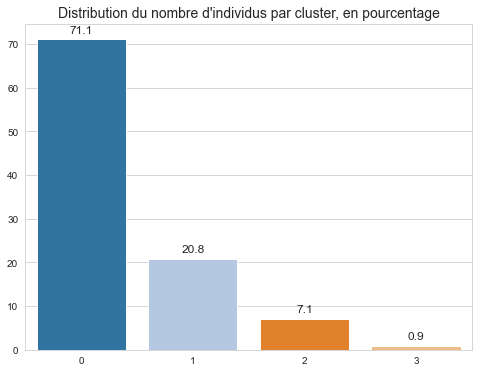

0    30711
1     8990
2     3066
3      400
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
# Changement des numéros de clusters pour avoir dans
# l'ordre décroissant en nombre de clients
X1_labeled_copy = X1_labeled.copy()
X1_labeled_copy["label"].replace([0, 1, 3, 2], [0, 1, 2, 3], inplace=True)

# Répartition des clusters
perc_cluster_repartition(X1_labeled_copy)

On a quasiment les mêmes pourcentages qu'avec le dataset entier.

In [16]:
def plot_var_cluster(X_with_col_label):

    """ Fonction pour visualiser la répartition des variables
    selon les clusters ( = labels)
        
    - Arguments :
        - X_with_col_label : dataframe d'origine avec la colonne label
    
    - Affiche :
        - 2 graphes pour chaque variable du dataframe X_with_col_label
            - barplot représentant la moyenne de la variable selon le cluster
            - boxplot de la variable selon le cluster
    """

    # On regroupe par label
    X_labeled = X_with_col_label.groupby("label").mean()

    for col in X_labeled.columns:

        # Initialisation de la figure
        f, axes = plt.subplots(1, 2, figsize=(15, 4))

        # boxplot de la variable selon le cluster
        sns.boxplot(
            y="label",
            x=col,
            data=X_with_col_label,
            orient="h",
            ax=axes[0],
            palette="tab20",
        )

        # barplot de la valeur moyenne de la variable selon le cluster
        sns.barplot(
            y=X_labeled.index,
            x=col,
            data=X_labeled,
            orient="h",
            ax=axes[1],
            palette="tab20",
        )

        plt.title("Moyenne de {} pour chaque cluster".format(col), size=14)
        plt.show()

<IPython.core.display.Javascript object>

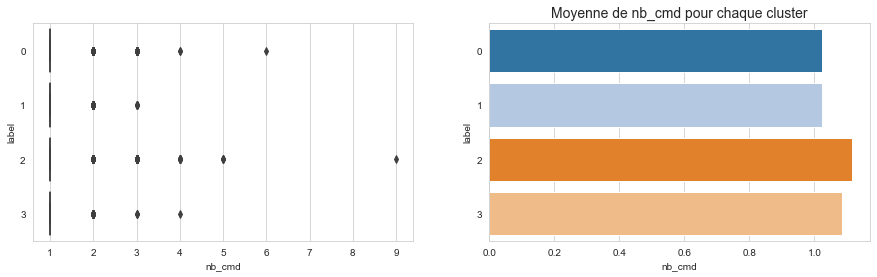

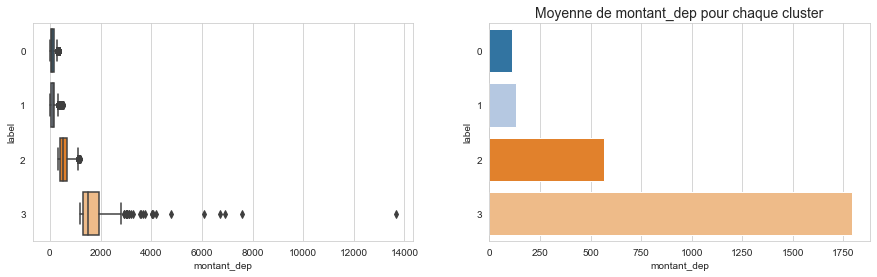

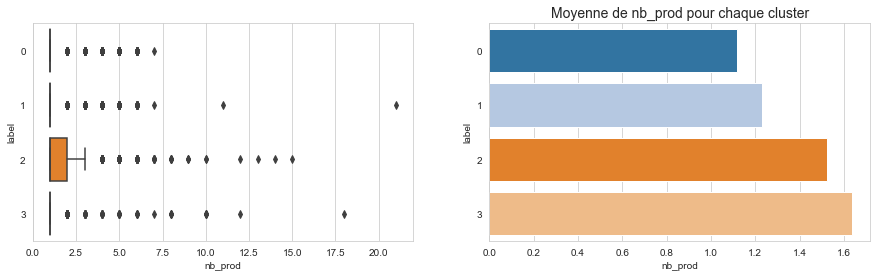

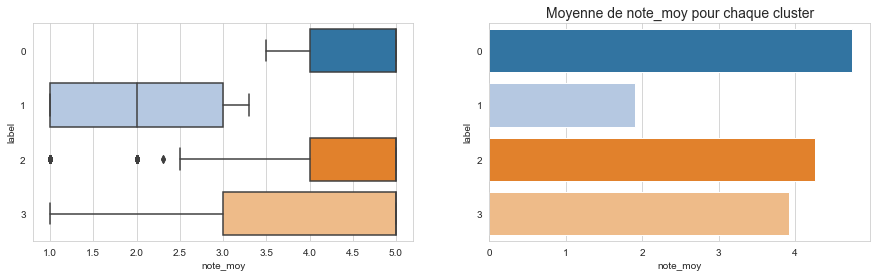

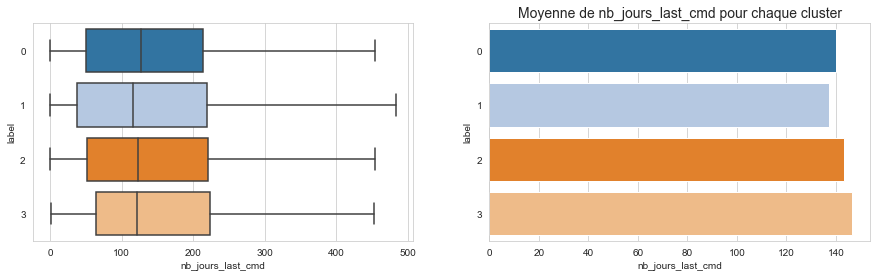

<IPython.core.display.Javascript object>

In [17]:
# Visualisation de la distribution des variables
plot_var_cluster(X1_labeled_copy)

On retrouve les mêmes distributions que celles obtenues avec le dataset entier.

#### b. Ajout de nouveaux clients

In [18]:
def results_ARI(time_range, kmeans_pred, scaler):

    """ Fonction pour stocker dans un dataframe pour chaque période donnée
     le nombre de clients, le nombre total de commandes, 
     le nombre total de produits commandésle score de l'ARI, 
     les scores de Silhouette
        
    - Arguments :
        - time_range : liste des périodes
        - kmeans_pred : kmeans entrainé sur la période de base, qui fera
        ici les prédictions
        - scaler : scaler utilisé pour le kmeans entrainé sur la période de base
    
    - Retourne :
        - un dataframe avec 
            - le mois auquel on fait la prédiction 
            (données s'arrêtent au dernier jour du mois précédent)
            - le nombre de clients
            - le nombre total de commandes
            - le nombre total de produits commandés
            - le score de l'ARI (Adjusted Range Index)
            - le score de Silhouette du kmeans de prédiction
            - le score de Silhouette du kmeans "true"
    """

    # Dataframe pour récupérer les résultats
    results_maj_month = pd.DataFrame(
        columns=[
            "mois_maj",
            "nombre_clients",
            "nombre_total_cmd",
            "nombre_total_prod_cmd",
            "ARI",
            "Silhouette_pred",
            "Silhouette_true",
        ]
    )

    for time in time_range:

        # Création du dataset augmenté de nouveaux clients
        X_aug = crea_df(df_all, time)

        # Nombre de clients
        nb_cust = X_aug.shape[0]

        # Nombre total de commandes
        nb_cmd_tot = X_aug["nb_cmd"].sum()

        # Nombre total de produits commandés
        nb_prod_tot = X_aug["nb_prod"].sum()

        # Normalisation des données modèle "true"
        robust_scal = RobustScaler().fit(
            X_aug[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
        )
        X_aug_scaled = robust_scal.transform(
            X_aug[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
        )

        # Normalisation des données modèle "predict"
        # utilise le scaler entrainé lors de la période de base
        X_aug_scaled_1 = scaler.transform(
            X_aug[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
        )

        # Modélisation
        kmeans_true = KMeans(n_clusters=4, random_state=1).fit(X_aug_scaled)

        # Récupération des "true" labels des clients
        labels_true = kmeans_true.predict(X_aug_scaled)

        # Récupération des "predicted" labels des clients
        label_pred = kmeans_pred.predict(X_aug_scaled_1)

        # On stocke les résultats
        results = {
            "mois_maj": time,
            "nombre_clients": nb_cust,
            "nombre_total_cmd": nb_cmd_tot,
            "nombre_total_prod_cmd": nb_prod_tot,
            "ARI": adjusted_rand_score(labels_true, label_pred),
            "Silhouette_pred": silhouette_score(X_aug_scaled_1, label_pred),
            "Silhouette_true": silhouette_score(X_aug_scaled, labels_true),
        }

        # On ajoute les résultats au dataframe
        results_maj_month = results_maj_month.append(results, ignore_index=True)

    return results_maj_month

<IPython.core.display.Javascript object>

In [19]:
# Périodicité par mois
time_range1 = np.arange("2018-01", "2018-11", dtype="datetime64[M]")

<IPython.core.display.Javascript object>

In [20]:
results_1 = results_ARI(time_range1, kmeans_1, robust_scal_1)
results_1

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp +

,mois_maj,nombre_clients,nombre_total_cmd,nombre_total_prod_cmd,ARI,Silhouette_pred,Silhouette_true
0,2018-01-01,43167,44511,50747,1.000000,0.526441,0.526441
1,2018-02-01,50090,51665,58877,0.997779,0.518243,0.519100
2,2018-03-01,56465,58305,66477,0.996059,0.512727,0.518644
3,2018-04-01,63352,65429,74621,0.997568,0.506522,0.520042
4,2018-05-01,70012,72307,82529,-1.823738,0.499403,0.519984
5,2018-06-01,76583,79126,90406,-12.027280,0.492663,0.519589
6,2018-07-01,82492,85260,97446,-3.163520,0.486035,0.519148
7,2018-08-01,88506,91488,104485,1.052570,0.479122,0.519242
8,2018-09-01,94720,97915,111704,0.859392,0.472319,0.518686
9,2018-10-01,94720,97916,111705,0.856725,0.472318,0.518691


<IPython.core.display.Javascript object>

Pour les clients à partir du mois de mai, le score d'ARI ne va plus du tout.

Par ailleurs, nous observons un warning indiquant RuntimeWarning: overflow encountered in long_scalars.

Une recherche sur internet nous indique qu'il faut redéfinir la fonction pour le calcul de l'ARI : il faut "forcer" à prendre les valeurs entières des vrais positifs (tp), faux positifs (fp), vrais négatis (tn) et faux négatifs (fn).

Source : https://github.com/TomDLT/scikit-learn/commit/4c3349bdc579af448af31c6bf305def991351c12

Remarque : dans la version 1.0.2 de scikit-learn, c'est bien la fonction ci-dessous qui est implémentée. La version de scikit-learn utilisée dans ce notebook est 0.24.2 car le passage à 1.0.2 générait des incompabilités avec d'autres packages.

In [21]:
def adjusted_rand_score_corrected(labels_true, labels_pred):

    """ Fonction pour corriger la façon de calculer le score de l'ARI
        
    - Arguments :
        - labels_true : vrais labels des clients
        - labels_pred : labels prédits des clients
    
    - Retourne :
        - le score de l'ARI en ayant pris les valeurs entières pour
        tn, fp, fn, tp
    """

    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)

    # convert to Python integer types, to avoid overflow or underflow
    tn, fp, fn, tp = int(tn), int(fp), int(fn), int(tp)

    # Special cases: empty data or full agreement
    if fn == 0 and fp == 0:
        return 1.0

    return 2.0 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))

<IPython.core.display.Javascript object>

In [22]:
def results_ARI_corrected(time_range, kmeans_pred, scaler):

    """ Fonction pour stocker dans un dataframe pour chaque période donnée
     le nombre de clients, le nombre total de commandes, 
     le nombre total de produits commandésle score de l'ARI, 
     les scores de Silhouette
        
    - Arguments :
        - time_range : liste des périodes
        - kmeans_pred : kmeans entrainé sur la période de base, qui fera
        ici les prédictions
        - scaler : scaler utilisé pour le kmeans entrainé sur la période de base
    
    - Retourne :
        - un dataframe avec 
            - le mois auquel on fait la prédiction 
            (données s'arrêtent au dernier jour du mois précédent)
            - le nombre de clients
            - le nombre total de commandes
            - le nombre total de produits commandés
            - le score de l'ARI (Adjusted Range Index)
            - le score de Silhouette du kmeans de prédiction
            - le score de Silhouette du kmeans "true"
    """

    # Dataframe pour récupérer les résultats
    results_maj_month = pd.DataFrame(
        columns=[
            "mois_maj",
            "nombre_clients",
            "nombre_total_cmd",
            "nombre_total_prod_cmd",
            "ARI",
            "Silhouette_pred",
            "Silhouette_true",
        ]
    )

    for time in time_range:

        # Création du dataset augmenté de nouveaux clients
        X_aug = crea_df(df_all, time)

        # Nombre de clients
        nb_cust = X_aug.shape[0]

        # Nombre total de commandes
        nb_cmd_tot = X_aug["nb_cmd"].sum()

        # Nombre total de produits commandés
        nb_prod_tot = X_aug["nb_prod"].sum()

        # Normalisation des données modèle "true"
        robust_scal = RobustScaler().fit(
            X_aug[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
        )
        X_aug_scaled = robust_scal.transform(
            X_aug[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
        )

        # Normalisation des données modèle "predict"
        # utilise le scaler entrainé lors de la période de base
        X_aug_scaled_1 = scaler.transform(
            X_aug[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
        )

        # Modélisation
        kmeans_true = KMeans(n_clusters=4, random_state=1).fit(X_aug_scaled)

        # Récupération des "true" labels des clients
        labels_true = kmeans_true.predict(X_aug_scaled)

        # Récupération des "predicted" labels des clients
        label_pred = kmeans_pred.predict(X_aug_scaled_1)

        # On stocke les résultats
        results = {
            "mois_maj": time,
            "nombre_clients": nb_cust,
            "nombre_total_cmd": nb_cmd_tot,
            "nombre_total_prod_cmd": nb_prod_tot,
            "ARI": adjusted_rand_score_corrected(labels_true, label_pred),
            "Silhouette_pred": silhouette_score(X_aug_scaled_1, label_pred),
            "Silhouette_true": silhouette_score(X_aug_scaled, labels_true),
        }

        # On ajoute les résultats au dataframe
        results_maj_month = results_maj_month.append(results, ignore_index=True)

    return results_maj_month

<IPython.core.display.Javascript object>

In [23]:
results_1_corrected = results_ARI_corrected(time_range1, kmeans_1, robust_scal_1)
results_1_corrected

,mois_maj,nombre_clients,nombre_total_cmd,nombre_total_prod_cmd,ARI,Silhouette_pred,Silhouette_true
0,2018-01-01,43167,44511,50747,1.000000,0.526441,0.526441
1,2018-02-01,50090,51665,58877,0.997779,0.518243,0.519100
2,2018-03-01,56465,58305,66477,0.996059,0.512727,0.518644
3,2018-04-01,63352,65429,74621,0.997568,0.506522,0.520042
4,2018-05-01,70012,72307,82529,0.996449,0.499403,0.519984
5,2018-06-01,76583,79126,90406,0.985744,0.492663,0.519589
6,2018-07-01,82492,85260,97446,0.990360,0.486035,0.519148
7,2018-08-01,88506,91488,104485,0.988658,0.479122,0.519242
8,2018-09-01,94720,97915,111704,0.989902,0.472319,0.518686
9,2018-10-01,94720,97916,111705,0.989709,0.472318,0.518691


<IPython.core.display.Javascript object>

Les premiers scores sont bien identiques à ceux trouvés précédemment.

On va visualiser les scores.

In [26]:
def plot_ARI_cust(df_results):

    """ Fonction pour visualiser l'ARI au cours d'une période
    ainsi que l'évolution du nombre de clients
        
    - Arguments :
        - df_results : dataframe contenant l'ARI et le nombre de clients
    
    - Affiche :
        - 1 graphe avec évolution de l'ARI et du nombre de clients
        en fonction du temps
    """

    # Visualisation de adjusted_rand_score
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Valeurs de adjusted_rand_score
    ax1.plot(
        df_results["mois_maj"], df_results["ARI"], color="black", label="ARI",
    )

    ax1.set_xlabel("mois_maj", size=14)
    ax1.set_ylabel("adjusted_rand_score", size=14)
    plt.legend(loc="center left")
    ax1.tick_params(axis="y", labelcolor="black")

    # Nombre de clients
    ax2 = ax1.twinx()

    ax2.set_ylabel("nombre_clients", color="blue", size=14)
    ax2.plot(
        df_results["mois_maj"], df_results["nombre_clients"], color="blue", ls="--",
    )
    ax2.tick_params(axis="y", labelcolor="blue")

    plt.show()

<IPython.core.display.Javascript object>

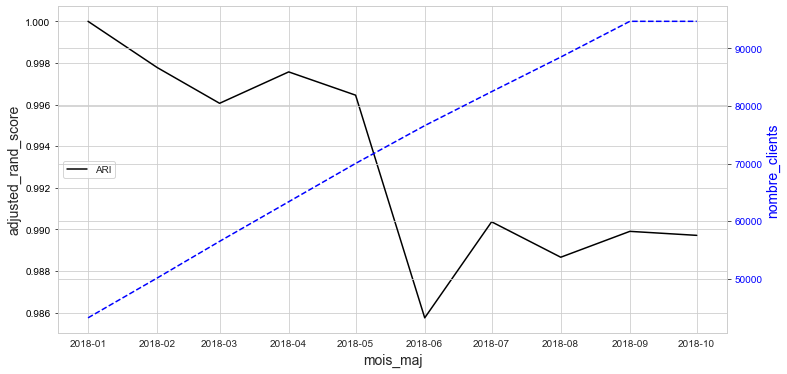

<IPython.core.display.Javascript object>

In [27]:
plot_ARI_cust(results_1_corrected)

On observe une chute du score au moins de juin 2018, soit au bout de 5 mois (les données sont prises jusqu'au 31 mai 2018 inclus).

Les valeurs de score sont très satisfaisantes (> 0.98).

In [28]:
def plot_silhouette(df_results):

    """ Fonction pour visualiser les scores de silhouettes 
    au cours d'une période
    
    - Arguments :
        - df_results : dataframe contenant les scores de silhouette
    
    - Affiche :
        - 1 graphe avec évolution des scores de silhouette avec 
        le modèle de base et avec le modèle "true" en fonction du temps
    """

    # Visualisation de adjusted_rand_score
    plt.figure(figsize=(12, 8))

    # Valeurs de silhouette prédites
    plt.scatter(
        df_results["mois_maj"], df_results["Silhouette_pred"], label="Silhouette_pred",
    )
    plt.xlabel("mois_maj", size=14)
    plt.ylabel("Silhouette_score", size=14)
    plt.legend(loc="center left")

    # Valeurs de silhouette "true"
    plt.scatter(
        df_results["mois_maj"], df_results["Silhouette_true"], label="Silhouette_true",
    )
    # ax.set_xlabel("mois_maj", size=14)
    # ax.set_ylabel("Silhouette_score", size=14)
    plt.legend(loc="center left")

    plt.show()

<IPython.core.display.Javascript object>

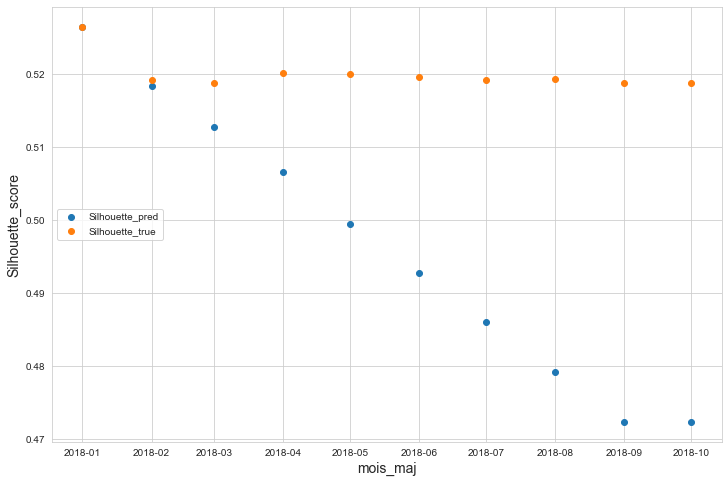

<IPython.core.display.Javascript object>

In [29]:
plot_silhouette(results_1_corrected)

On a une diminution régulière du score de silhouette pour le modèle de prédiction.

In [32]:
def plot_ARI_cmd(df_results):

    """ Fonction pour visualiser l'ARI au cours d'une période
    ainsi que l'évolution du nombre total de commandes
        
    - Arguments :
        - df_results : dataframe contenant l'ARI et le nombre total 
        de commandes
    
    - Affiche :
        - 1 graphe avec évolution de l'ARI et du nombre total de commandes
        en fonction du temps
    """

    # Visualisation de adjusted_rand_score
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Valeurs de adjusted_rand_score
    ax1.plot(
        df_results["mois_maj"], df_results["ARI"], color="black", label="ARI",
    )

    ax1.set_xlabel("mois_maj", size=14)
    ax1.set_ylabel("adjusted_rand_score", size=14)
    plt.legend(loc="center left")
    ax1.tick_params(axis="y", labelcolor="black")

    # Nombre de clients
    ax2 = ax1.twinx()

    ax2.set_ylabel("nombre_total_cmd", color="red", size=14)
    ax2.plot(
        df_results["mois_maj"], df_results["nombre_total_cmd"], color="red", ls="--",
    )
    ax2.tick_params(axis="y", labelcolor="red")

    plt.show()

<IPython.core.display.Javascript object>

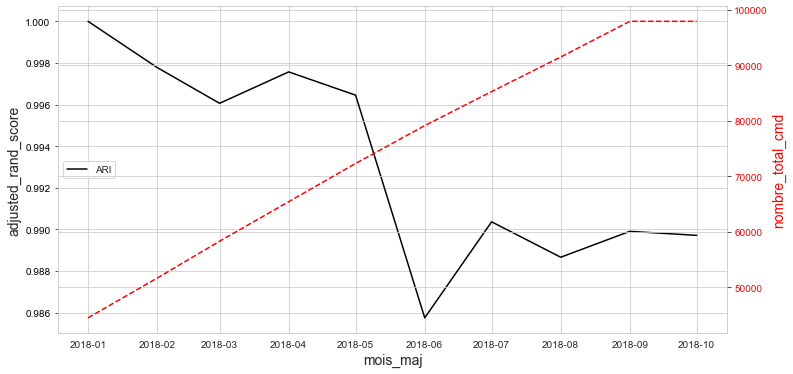

<IPython.core.display.Javascript object>

In [33]:
plot_ARI_cmd(results_1_corrected)

On a une augmentation linéaire du nombre total de commandes.

### 2.2. Dataset période de base 2 : sept 2016 - aout 2017

On va prendre comme deuxième dataset un dataset qui couvre septembre 2016 à août 2017 inclus.

In [34]:
# Date limite
date_limit_2 = np.datetime64("2017-08-31 23:59:59")

# Dataset d'origine jusqu'au 31/08/2017 inclus
X2 = crea_df(df_all, date_limit_2)
X2.shape

(22182, 5)

<IPython.core.display.Javascript object>

#### a. Préparation des données
##### Normalisation des données

In [35]:
# Normalisation des données avec RobustScaler
# Sur les 3 variables montant_dep, note_moy, nb_jours_last_cmd
robust_scal_2 = RobustScaler().fit(X2[["montant_dep", "note_moy", "nb_jours_last_cmd"]])
X2_scaled = robust_scal_2.transform(
    X2[["montant_dep", "note_moy", "nb_jours_last_cmd"]]
)
X2_scaled.shape

(22182, 3)

<IPython.core.display.Javascript object>

##### Entrainement du modèle sur période de base

In [36]:
# Modèle de base
kmeans_2 = KMeans(n_clusters=4, random_state=1).fit(X2_scaled)
labels_2 = kmeans_2.labels_

# Calcul du coefficient de silhouette
silhouette_score_2 = silhouette_score(X2_scaled, labels_2)
silhouette_score_2

0.5171058297627321

<IPython.core.display.Javascript object>

Score de silhouette légèrement inférieur par rapport à la période précédente.

##### Observation de la répartition des clusters obtenus

In [37]:
X2_labeled = df_with_col_label(labels_2, X2)
X2_labeled

,nb_cmd,montant_dep,nb_prod,note_moy,nb_jours_last_cmd,label
customer_unique_id,,,,,,
0000f46a3911fa3c0805444483337064,1,86.22,1,3.0,174.121481,2
0005e1862207bf6ccc02e4228effd9a0,1,150.12,1,4.0,180.019294,3
0006fdc98a402fceb4eb0ee528f6a8d4,1,29.00,1,3.0,44.608900,2
000a5ad9c4601d2bbdd9ed765d5213b3,1,91.28,1,4.0,20.426898,3
000de6019bb59f34c099a907c151d855,1,257.44,2,2.0,14.200995,2
...,...,...,...,...,...,...
fff1afc79f6b5db1e235a4a6c30ceda7,1,50.09,1,5.0,1.014769,3
fff3a9369e4b7102fab406a334a678c3,1,102.74,1,5.0,20.564826,3
fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2,5.0,84.124572,1


<IPython.core.display.Javascript object>

In [38]:
X2_labeled["label"].value_counts()

3    16576
2     4441
0     1068
1       97
Name: label, dtype: int64

<IPython.core.display.Javascript object>

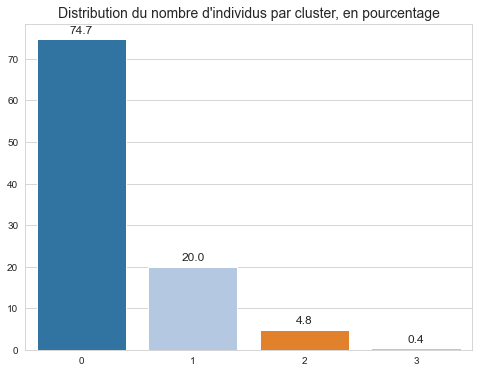

0    16576
1     4441
2     1068
3       97
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [39]:
# Changement des numéros de clusters pour avoir dans
# l'ordre décroissant en nombre de clients
X2_labeled_copy = X2_labeled.copy()
X2_labeled_copy["label"].replace([3, 2, 0, 1], [0, 1, 2, 3], inplace=True)

# Répartition des clusters
perc_cluster_repartition(X2_labeled_copy)

On a des pourcentages plus faibles pour les clusters les moins peuplés et un pourcentage plus élevé pour le cluster le plus peuplé.

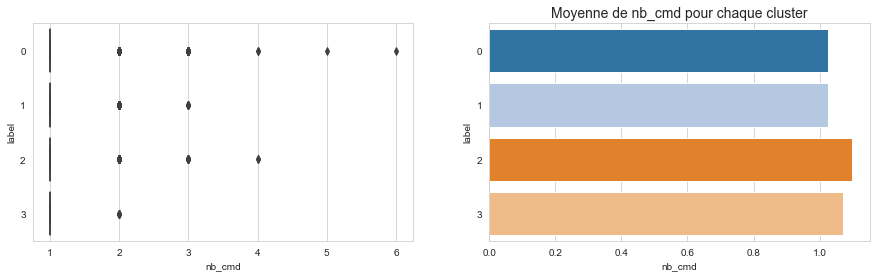

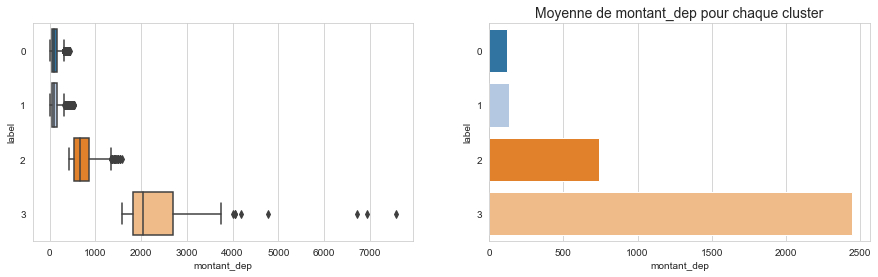

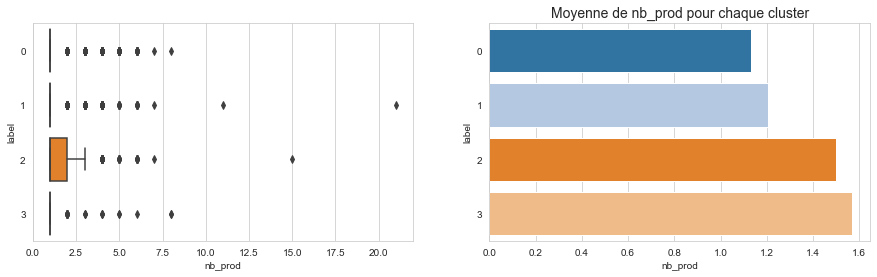

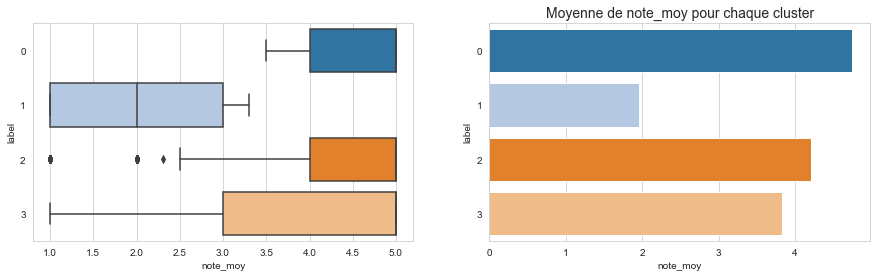

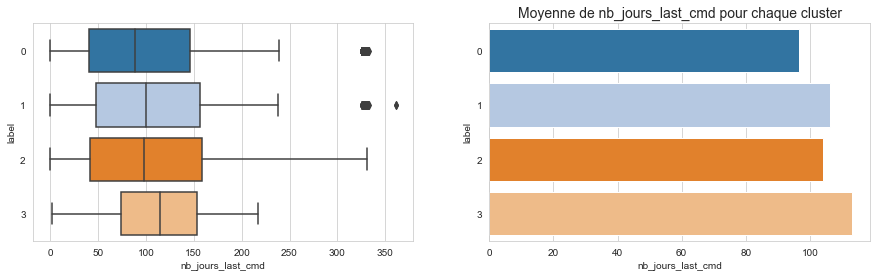

<IPython.core.display.Javascript object>

In [40]:
# Visualisation de la distribution des variables
plot_var_cluster(X2_labeled_copy)

On retrouve à peu près les même distributions de variables que sur l'ensemble du dataset.

On note que le cluster 3 a une moyenne de nb_jours_last_cmd un peu plus élevée que les autres groupes.

#### b. Ajout de nouveaux clients

In [41]:
# Périodicité par mois
time_range2 = np.arange("2017-09", "2018-11", dtype="datetime64[M]")

<IPython.core.display.Javascript object>

In [42]:
results_2_corrected = results_ARI_corrected(time_range2, kmeans_2, robust_scal_2)
results_2_corrected

,mois_maj,nombre_clients,nombre_total_cmd,nombre_total_prod_cmd,ARI,Silhouette_pred,Silhouette_true
0,2017-09-01,22182,22815,25864,1.000000,0.517106,0.517106
1,2017-10-01,26242,27024,30658,0.961535,0.505179,0.511260
2,2017-11-01,30617,31554,35927,0.993573,0.491790,0.516489
3,2017-12-01,37776,38944,44510,0.993810,0.476371,0.521503
4,2018-01-01,43167,44511,50747,0.921938,0.468338,0.526441
5,2018-02-01,50090,51665,58877,0.920568,0.456306,0.519100
6,2018-03-01,56465,58305,66477,0.921656,0.448469,0.518644
7,2018-04-01,63352,65429,74621,0.927195,0.440039,0.520042
8,2018-05-01,70012,72307,82529,0.929423,0.429553,0.519984
9,2018-06-01,76583,79126,90406,0.940378,0.419709,0.519589


<IPython.core.display.Javascript object>

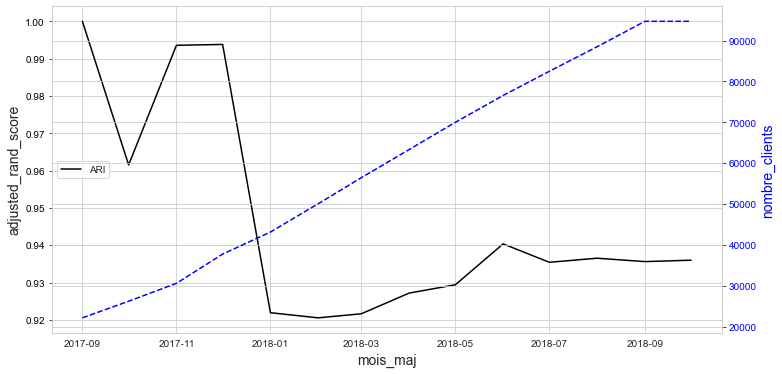

<IPython.core.display.Javascript object>

In [43]:
# Visualisation des résultats ARI
plot_ARI_cust(results_2_corrected)

On remarque une chute importante du score de l'ARI entre décembre 2017 et janvier 2018. On observe une bosse entre novembre de décembre, suite à une augmentation de clients.

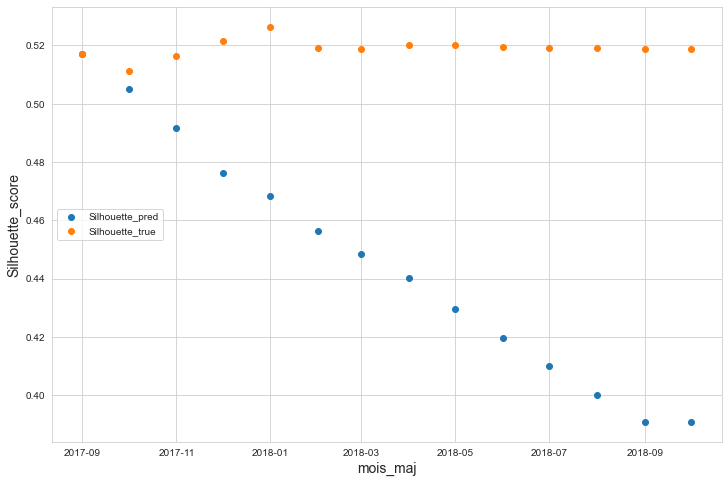

<IPython.core.display.Javascript object>

In [44]:
# Visualisation des résultats pour les scores de silhouette
plot_silhouette(results_2_corrected)

On a une diminution régulière du score de silhouette pour le modèle de prédiction.

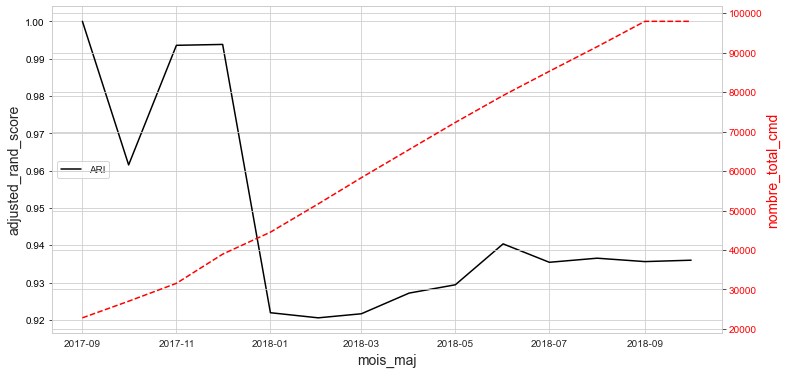

<IPython.core.display.Javascript object>

In [45]:
plot_ARI_cmd(results_2_corrected)

On observe une petite bosse pour le nombre total de commandes entre novembre et décembre 2017.